In [5]:
import numpy as np
import pandas as pd
import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rcParams 
from tqdm import tqdm
from datetime import datetime
from IPython.display import IFrame

#========================   PATHS   ========================#
TRAIN_PATH= 'data/train.csv'
TEST_PATH= 'data/test.csv'
MASK_PATH= 'https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png'
CNG_PATH= 'img/congestion_table.png' #congestion table
SAF_PATH= 'img/seasonalAdjFac.png' #seasonality adjustment factor

# Load Datasets
#### Train Dataset
    The train dataset contains ove 55,423,856 rows and 7 columns, making it hard to manipulate. The following solution parts the dataset into chunks that are afterwards concatenated. Also, it includes a faster way to read date type values, than the pre-defined parse_date parameter of read_csv.
Source: [kaggle](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows)

In [4]:
%%time

df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000 # 5m rows chunks

# Columns to keep and input for dtype
traintypes = {'fare_amount': np.float32,
              'pickup_datetime': str, 
              'pickup_longitude': np.float32,
              'pickup_latitude': np.float32,
              'dropoff_longitude': np.float32,
              'dropoff_latitude': np.float32,
              'passenger_count': int}


for df_chunk in tqdm(pd.read_csv(TRAIN_PATH,
                                 nrows= 5_000_000,
                                 usecols= list(traintypes.keys()),
                                 dtype= traintypes,
                                 chunksize= chunksize)):
     
    # Faster than using parse_dates
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str[0: 13]
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'],
                                                 utc=True, 
                                                 format='%Y/%m/%d %H')
    df_list.append(df_chunk) 

        
# Merge all dataframes into one dataframe
train = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list



1it [00:15, 15.17s/it]


CPU times: user 13.6 s, sys: 2.16 s, total: 15.8 s
Wall time: 15.6 s


In [5]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:00:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:00:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:00:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:00:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:00:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


#### Load Test Datset

In [6]:
test = pd.read_csv(TEST_PATH, usecols=[1,2,3,4,5,6], header= 0)
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


## Data Cleaning
#### Remove duplicates

In [7]:
print(f"From {train.shape[0]} rows,")
train.drop_duplicates(inplace=True)
print(f"to {train.shape[0]} rows")

From 5000000 rows,
to 4998527 rows


#### Remove Null values

In [8]:
#check for missing values
print(f"Missing values in TRAIN datset: \n{train.isnull().sum().sort_values(ascending=False)}\n")
print(f"Missing values in TEST datset: \n{test.isnull().sum().sort_values(ascending=False)}\n")

#drop the missing values
indexes = list(train.loc[train.isnull().any(1)].index)
train.drop(index= indexes, inplace= True)

Missing values in TRAIN datset: 
dropoff_latitude     36
dropoff_longitude    36
passenger_count       0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
fare_amount           0
dtype: int64

Missing values in TEST datset: 
passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
dtype: int64



#### Variable Fares 
    There are fares with negative or zero values. The corresponding rows are removed.

In [11]:
# Description
print(train['fare_amount'].describe())

bad_values= train.loc[train['fare_amount']<=0].index
print(f"\nRows with negative/ zero values: {len(bad_values)}")

# Remove rows
train.drop(bad_values, axis=0, inplace=True)

count    4.998491e+06
mean     1.132128e+01
std      9.775764e+00
min     -1.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

Rows with negative/ zero values: 343


#### Variable Passengers 
    On the train dataset, there are rides with zero or negative passengers. Also, there are rides with an excessive amount of passengers. The corresponding rows are removed.

In [12]:
print("Passengers in the test dataset:", test['passenger_count'].describe())
print("\nPassengers in the train dataset:", train['passenger_count'].describe())

# Position of rows
bad_values= list(train.loc[train['passenger_count']>12].index) + \
            list(train.loc[train['passenger_count']<=0].index)

# Deletion
train.drop(index= bad_values, inplace=True)

Passengers in the test dataset: count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Passengers in the train dataset: count    4.998148e+06
mean     1.684875e+00
std      1.331980e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64


#### Date Variable

In [13]:
print(f"Earliest date: {train['pickup_datetime'].min()}")
print(f"Latest date: {train['pickup_datetime'].max()}")
print(f"Time Span: {train['pickup_datetime'].max() -train['pickup_datetime'].min()}")

Earliest date: 2009-01-01 00:00:00+00:00
Latest date: 2015-06-30 23:00:00+00:00
Time Span: 2371 days 23:00:00


#### Spatial Variables
   Initially, the bounds of the NYC are set, as they were drawn on the map of [boundingbox](https://boundingbox.klokantech.com/). Then, the dataset is filtered. 

In [14]:
# Boundaries of the metropolitan area
Boundaries = (-74.3, -73.6, 40.5, 41)
long_lim = list(Boundaries[0:2])
lat_lim = list(Boundaries[2:4])


# NYC Coordinates
nyc = (40.7141667, -74.0063889)
# Airports Coordinates
jfk= (40.6441666667, -73.7822222222)
lgd= (40.7769271, -73.87396590000003)



# Remove rides outside the metropolitan area
# Longitude
train = train[(train.pickup_longitude> long_lim[0]) & (train.pickup_longitude < long_lim[1])]
train = train[(train.dropoff_longitude> long_lim[0]) & (train.dropoff_longitude < long_lim[1])]
# Latitude
train = train[(train.pickup_latitude> lat_lim[0]) & (train.pickup_latitude < lat_lim[1])]
train = train[(train.dropoff_latitude> lat_lim[0]) & (train.dropoff_latitude < lat_lim[1])]

#### Mask datapoints in the water
    A number of points are located on coordinates that correspond to sea or rivers. These datapoints are detected, with a mask from a map of the area, and are deleted. Initially, the mask is transformed in order to only contain 0 and 1 values. Then, the coordinates are transformed to the local X~Y system and the mask is applied to eliminate fault datapoints.

In [15]:
# Load mask
mask = plt.imread(MASK_PATH)[:,:,0] #y first, x second

# Need to make it boolean in order to use it as mask
print("Unique values before:\n\n",np.unique(mask))

mask = mask>0.5
print("\nUnique values after:\n\n",np.unique(mask))

Unique values before:

 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.02745098
 0.03529412 0.05490196 0.05882353 0.06666667 0.07450981 0.08235294
 0.08627451 0.09019608 0.09803922 0.12156863 0.12941177 0.14509805
 0.14901961 0.16470589 0.16862746 0.22745098 0.23921569 0.26666668
 0.27058825 0.32941177 0.33333334 0.34117648 0.37254903 0.3882353
 0.4117647  0.41568628 0.48235294 0.52156866 0.54509807 0.58431375
 0.59607846 0.627451   0.6666667  0.68235296 0.70980394 0.7137255
 0.72156864 0.73333335 0.7411765  0.7764706  0.7882353  0.8235294
 0.827451   0.85490197 0.8627451  0.88235295 0.8862745  0.9019608
 0.92156863 0.92941177 0.9411765  0.9529412  0.9607843  0.9764706
 0.98039216 1.        ]

Unique values after:

 [False  True]


In [16]:
def to_XY (longitude, latitude, mask, Boundaries):
    minLongitude = Boundaries[0]
    minLatitude = Boundaries[2]
    
    length = Boundaries[1] - minLongitude
    width = Boundaries[3] - minLatitude
    
    mask_length = mask.shape[1]
    mask_width = mask.shape[0]
    
    x = mask_length * (longitude - minLongitude) / length
    y = mask_width * (1 - (latitude - minLatitude) / width ) #imread reads from +y to -y

    
    return x.astype("int") ,y.astype("int")

#===================================================================================

# Application

pickupX, pickupY = to_XY(longitude= train.pickup_longitude, 
                         latitude= train.pickup_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

dropoffX, dropoffY = to_XY(longitude= train.dropoff_longitude, 
                         latitude= train.dropoff_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

# Multiply X,Ys with the mask
# Bitwise addition to concatenate all points into one array
idx = mask[pickupY, pickupX] & mask[dropoffY, dropoffX]
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 52071


In [17]:
print(f"From {train.shape[0]} rows,")

# Keep only points in land
train = train[idx]

print(f"to {train.shape[0]} rows.")

From 4872759 rows,
to 4820688 rows.


## Visualise datapoints
    For a sample from the dataset the spatial points are ploted. The magnitude of the points is sufficient to view an abstract mapping of the metropolitan area. Also, it is interesting to see that the vast majority of the geospatial points are located in Manhattan

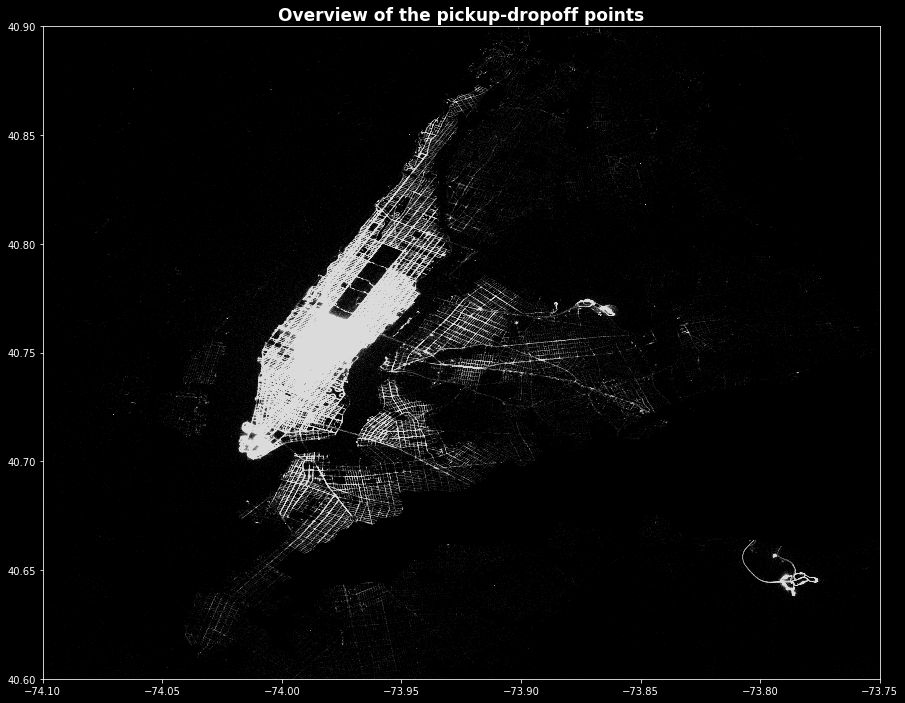

CPU times: user 6.16 s, sys: 1.67 s, total: 7.83 s
Wall time: 5.76 s


In [18]:
%%time
%matplotlib inline

# Plot pickups, dropoffs
plot_df= train

a1 = list(plot_df.pickup_longitude)
a2 = list(plot_df.pickup_latitude)

b1 = list(plot_df.dropoff_longitude)
b2 = list(plot_df.dropoff_latitude)

# Plot 

plt.style.use('dark_background')
plt.figure(figsize = (15,12))

plt.plot( a1, a2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.plot( b1, b2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.title(label= "Overview of the pickup-dropoff points", fontdict= {'weight' : 'bold', 'size'   : 17})

plt.xlim((-74.1, -73.75))
plt.ylim((40.6, 40.9))
plt.show()

## New Column
    According to our instructions, we have created a new column containing a traffic congestion factor for every given datetime. It takes into consideration daily variance of traffic congestion, as well as seasonal variance.
Sources:
         [Traffic Congestion Statistics](https://www.tomtom.com/en_gb/trafficindex/city/new-york) \
         [Seasonal Adjustment Factors](https://www.dot.ny.gov/divisions/engineering/technical-services/hds-respository/Tab/NYSDOT_2017_Seasonal_Adjustment_Factors.pdf)

In [ ]:
'''
    To use the seasonality table, we estimate the factor group to be  from the road network lengths 
    from the congestion table.
    
    Seasonality:
    H_ratio * suburban + nH_ratio * urban
    
    From the congestion table we can derive the following information.
    
    Yearly:
    cong_yearly
    
    Mon-Fri (5:00 to 10:00):
    cong_morning
    
    Mon_Fri (16:00 to 20:00):
    cong_afternoon
    
    The overall percentages to be associated with each pickup_datetime will be the product of the 
    percentage increases above.
'''
# Seasonality



# Highway - Non-Highway ratio
H_ratio = 3_435 / 98_091
nH_ratio = 1 - H_ratio

## Appendix

In [10]:
# Traffic Congestion Statistics
IFrame(CNG_PATH, width=960, height=1000)

In [11]:
# Seasonal Adjustment Factors
IFrame(SAF_PATH, width=960, height=1000)